In [2]:
import argparse
import gc
import logging
import os
import sys
import time

from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim

from sgan.data.loader import data_loader
from sgan.losses_argo import gan_g_loss, gan_d_loss, l2_loss
from sgan.losses_argo import displacement_error, final_displacement_error

from sgan.models_argo import TrajectoryGenerator, TrajectoryDiscriminator
from sgan.utils import int_tuple, bool_flag, get_total_norm
from sgan.utils import relative_to_abs, get_dset_path

from sgan.data.data import Argoverse_Social_Data, collate_traj_social
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import numpy as np
torch.backends.cudnn.benchmark = True

from matplotlib import pyplot as plt

from matplotlib import pyplot as plt
from argoverse.map_representation.map_api import ArgoverseMap
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.visualization.visualize_sequences import viz_sequence
avm = ArgoverseMap()

In [3]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(m.weight)
        
def get_dtypes(use_gpu=True):
    long_dtype = torch.LongTensor
    float_dtype = torch.FloatTensor
    if use_gpu == 1:
        long_dtype = torch.cuda.LongTensor
        float_dtype = torch.cuda.FloatTensor
    return long_dtype, float_dtype        

In [4]:
def relativeToAbsolute(traj, R, t):    
    seq_len = traj.shape[0] 
    traj = np.reshape(traj, (-1, 2))
    
    traj = np.swapaxes(traj, 1, 0)
    traj = np.matmul(R.T,traj)
    traj = np.swapaxes(traj, 1, 0)
    traj = traj + t
    traj = np.reshape(traj, (seq_len, -1, 2))
    return traj

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
long_dtype, float_dtype = get_dtypes()

argoverse_val   = Argoverse_Social_Data('../../deep_prediction/data/val/data')
argoverse_test  = Argoverse_Social_Data('../../deep_prediction/data/test_obs/data')
# sample_data  = Argoverse_Social_Data('../forecasting_sample/data')

test_size=len(argoverse_test)

In [8]:
batch_size = 1
val_loader = DataLoader(argoverse_val, batch_size=batch_size,
                    shuffle=False, num_workers=2,collate_fn=collate_traj_social)
# sample_loader = DataLoader(sample_data, batch_size=batch_size,
#                 shuffle=True, num_workers=2,collate_fn=collate_traj_social)

test_loader = DataLoader(argoverse_test, batch_size=batch_size,
                shuffle=False, num_workers=2,collate_fn=collate_traj_social)

In [9]:
generator = TrajectoryGenerator(
    obs_len=20,
    pred_len=30,
    embedding_dim=16,
    encoder_h_dim=32,
    decoder_h_dim=32,
    mlp_dim=64,
    num_layers=1,
    noise_dim=(8, ),
    noise_type='gaussian',
    noise_mix_type='global',
    pooling_type='pool_net',
    pool_every_timestep=0,
    dropout=0,
    bottleneck_dim=32,
    neighborhood_size=2.0,
    grid_size=8,
    batch_norm=False)

generator.apply(init_weights)
generator.type(float_dtype).train()

TrajectoryGenerator(
  (encoder): Encoder(
    (encoder): LSTM(16, 32)
    (spatial_embedding): Linear(in_features=2, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (decoder): LSTM(16, 32)
    (spatial_embedding): Linear(in_features=2, out_features=16, bias=True)
    (hidden2pos): Linear(in_features=32, out_features=2, bias=True)
  )
  (pool_net): PoolHiddenNet(
    (spatial_embedding): Linear(in_features=2, out_features=16, bias=True)
    (mlp_pre_pool): Sequential(
      (0): Linear(in_features=48, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=32, bias=True)
      (3): ReLU()
    )
  )
  (mlp_decoder_context): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24, bias=True)
    (3): ReLU()
  )
)

In [10]:
output_dir = '../saved_model/07-05-2020::19:37:23/'
checkpoint_name = 'gan_test'
restore_path = os.path.join(output_dir,'%s_with_model.pt' % checkpoint_name)

checkpoint = torch.load(restore_path)
generator.load_state_dict(checkpoint['g_state'])

<All keys matched successfully>

In [11]:
def poly_fit(traj, traj_len=30, threshold=0.002):
    """
    Input:
    - traj: Numpy array of shape (2, traj_len)
    - traj_len: Len of trajectory
    - threshold: Minimum error to be considered for non linear traj
    Output:
    - int: 1 -> Non Linear 0-> Linear
    """
    t = np.linspace(0, traj_len - 1, traj_len)
    res_x = np.polyfit(t, traj[:, 0], 2, full=True)[1]
    res_y = np.polyfit(t, traj[:, 1], 2, full=True)[1]
    
    if res_x + res_y >= threshold:
        return 1.0
    else:
        return 0.0

In [135]:
def predict_single_traj(train_agent, neighbour, av, seq_path, seq_id, Rs, ts):

    obs_traj = train_agent[0].unsqueeze(0)
    obs_traj = torch.cat((obs_traj, av[0].unsqueeze(0)),0)
    obs_traj = torch.cat((obs_traj, neighbour[0]),0)    
    
    ped_count = obs_traj.shape[0]
    seq_start_end = [[0, ped_count]] # last number excluded
    
    for i in range(1, len(neighbour)):
        obs_traj = torch.cat((obs_traj, train_agent[i].unsqueeze(0)), 0)
        obs_traj = torch.cat((obs_traj, av[i].unsqueeze(0)),0)
        obs_traj = torch.cat((obs_traj, neighbour[i]), 0) 
        
        seq_start_end.append([ped_count, obs_traj.shape[0]])

        num_peds_considered = obs_traj.shape[0] - ped_count
        ped_count = obs_traj.shape[0]

    obs_traj_rel = torch.zeros(obs_traj.shape)
    obs_traj_rel[:,1:,:] = obs_traj[:,1:,:] -  obs_traj[:,:-1,:]    
    seq_start_end = torch.tensor(seq_start_end)

    obs_traj = obs_traj.transpose_(0,1).cuda() 
    obs_traj_rel = obs_traj_rel.transpose_(0,1).cuda() 
    
    pred_traj_fake_rel = generator(obs_traj, obs_traj_rel, seq_start_end)
    pred_traj_fake = relative_to_abs(pred_traj_fake_rel, obs_traj[-1])
    
    
    pred_traj = torch.cat((obs_traj, pred_traj_fake), 0 )
    pred_traj = pred_traj.cpu().detach().numpy()
    
    pred_agv_traj = np.swapaxes(pred_traj,0,1)[0]
 
    return pred_agv_traj

In [102]:
def prediction_const_vel(trajectory,num_points=30,avg_points=1):
    #a simple prediction function that predict straight line with constant velocity
    velocity_x_mps = []
    velocity_y_mps = []
    
    for i in range(1,avg_points+1,1):
        velocity_x_mps.append(trajectory[-i,0] - trajectory[-(1+i),0])
        velocity_y_mps.append(trajectory[-i,1] - trajectory[-(1+i),1])
        
    velocity_x_mps = np.mean(velocity_x_mps)
    velocity_y_mps = np.mean(velocity_y_mps)
    
    current_traj = trajectory[-1]
    results = np.zeros((len(trajectory)+num_points,2))
    
    results[0:len(trajectory)] = trajectory
    
    for i in range(num_points):
        results[len(trajectory)+i] = np.array([current_traj[0]+velocity_x_mps,current_traj[1]+velocity_y_mps])
        current_traj = results[len(trajectory)+i]
    return results

In [103]:
dataiter = iter(val_loader)

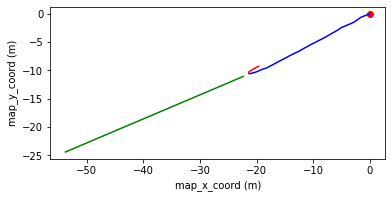

In [136]:
output_all = {}
counter = 0
batch = dataiter.next()

# print(batch)

train_agent = batch['train_agent']
neighbour = batch['neighbour']
av = batch['av']
av_gt = batch['av_gt']
seq_path = batch['seq_path']
seq_id = batch['indexes']
Rs = batch['rotation']
ts = batch['translation']
gt_agent = batch['gt_agent']

# pred_traj_gt = gt_agent[0].unsqueeze(0)
# pred_traj_gt_ = np.array(pred_traj_gt.cpu())
# pred_traj_gt_c=pred_traj_gt_.squeeze(0)

sgan_traj = predict_single_traj(train_agent, neighbour, av, seq_path, seq_id, Rs, ts)

const_vel_traj=prediction_const_vel(np.asarray(train_agent[0]), avg_points=5)

ax = plt.gca()
plt.plot(sgan_traj[0,0],sgan_traj[0,1],'-o',c='r') #starting point here
plt.plot(sgan_traj[:21,0],sgan_traj[:21,1],'-',c='b')
plt.plot(sgan_traj[20:,0],sgan_traj[20:,1],'-',c='r')
plt.plot(const_vel_traj[20:,0],const_vel_traj[20:,1],'-',c='g')


plt.xlabel('map_x_coord (m)')
plt.ylabel('map_y_coord (m)')
ax.set_aspect('equal')
plt.show()

In [90]:

def get_ade(forecasted_trajectory: np.ndarray, gt_trajectory: np.ndarray) -> float:
    """Compute Average Displacement Error.
    Args:
        forecasted_trajectory: Predicted trajectory with shape (pred_len x 2)
        gt_trajectory: Ground truth trajectory with shape (pred_len x 2)
    Returns:
        ade: Average Displacement Error
    """
    pred_len = forecasted_trajectory.shape[0]
    ade = float(
        sum(
            math.sqrt(
                (forecasted_trajectory[i, 0] - gt_trajectory[i, 0]) ** 2
                + (forecasted_trajectory[i, 1] - gt_trajectory[i, 1]) ** 2
            )
            for i in range(pred_len)
        )
        / pred_len
    )
    return ade

def get_fde(forecasted_trajectory: np.ndarray, gt_trajectory: np.ndarray) -> float:
    """Compute Final Displacement Error.
    Args:
        forecasted_trajectory: Predicted trajectory with shape (pred_len x 2)
        gt_trajectory: Ground truth trajectory with shape (pred_len x 2)
    Returns:
        fde: Final Displacement Error
    """
    fde = math.sqrt(
        (forecasted_trajectory[-1, 0] - gt_trajectory[-1, 0]) ** 2
        + (forecasted_trajectory[-1, 1] - gt_trajectory[-1, 1]) ** 2
    )
    return fde

FDE = get_fde(predict_traj[20:], pred_traj_gt_c)
ADE = get_ade(predict_traj[20:], pred_traj_gt_c)
print('ADE is ', ADE)
print('FDE is ', FDE)

NameError: name 'math' is not defined

In [130]:
# predict_traj = get_multiple_forecasts()

In [15]:
# ax = plt.gca()

# plt.plot(predict_traj[0,0,0],predict_traj[0,0,1],'-o',c='r') #starting point here
# plt.plot(predict_traj[0,:21,0],predict_traj[0,:21,1],'-',c='b')

# for i in range(len(predict_traj)):
#     plt.plot(predict_traj[i,20:,0],predict_traj[i,20:,1],'-',c=np.random.rand(3,))
# plt.xlabel('map_x_coord (m)')
# plt.ylabel('map_y_coord (m)')
# ax.set_aspect('equal')
# plt.show()

In [16]:
# def get_multiple_forecasts():
    
#     batch = dataiter.next()
#     print(batch)
#     train_agent = batch['train_agent']
#     neighbour = batch['neighbour']
#     av = batch['av']
#     seq_path = batch['seq_path']
#     seq_id = batch['indexes']
#     Rs = batch['rotation']
#     ts = batch['translation']

#     predict_traj = []
#     for i in range(9,3,-1):
#         predict_traj.append(predict_single_traj(train_agent, neighbour, av, seq_path, seq_id, Rs, ts))
                
#     return int(seq_id[0]), np.array(predict_traj)

In [157]:
dataiter = iter(test_loader)
output_all = {}
counter = 1

test_size=len(argoverse_test)


for test_i in range (test_size):
    batch = dataiter.next()
    train_agent = batch['train_agent']
    neighbour = batch['neighbour']
    av = batch['av']
    seq_path = batch['seq_path']
    seq_id = batch['indexes']
    Rs = batch['rotation']
    ts = batch['translation']
    
    predict_traj = []
    for i in range(9,3,-1):
        predict_traj.append(predict_single_traj(train_agent, neighbour, av, seq_path, seq_id, Rs, ts))
        
    predict_traj = np.array(predict_traj)
    idx = int(seq_path[0][41:-4])
    output_all[idx] = predict_traj[:,20:50,:]
    counter += 1
    print(idx)
    
    if counter>1000:
        break
    
    

56283
18521
1583
31217
68745
9935
62800
47694
72060
50147
69750
67924
63973
63877
61308
4580
8605
62249
79664
25219
13323
45814
47568
35355
27614
7739
57448
14293
7089
62218
71747
3306
2312
3723
16990
61502
73635
30418
35178
34656
16607
70967
51838
37380
40446
53915
78233
50684
22171
36765
19572
53239
20534
65335
41441
43898
49536
17205
16536
26705
7643
41051
9177
59456
17528
31050
80042
15128
44325
17526
71508
23524
69817
41124
50921
35295
80477
24703
6022
36461
4701
40526
11393
19510
56897
35170
13599
21722
1869
58878
37701
19561
61842
73514
77160
72495
63993
13612
75669
35128
59850
7818
74654
59351
25691
3677
33114
5269
76891
416
71154
25017
44446
4907
6233
21664
10834
25457
45431
65274
57735
18944
78125
17469
3712
11263
45632
10264
5389
62005
33792
31747
66037
59561
42692
4924
61254
6521
13748
1892
15326
52899
67936
34799
49630
3764
72853
29280
32979
11180
838
16834
67870
42163
44631
9800
37665
21362
43547
25392
10880
35530
15393
48091
80527
29170
56196
53521
43383
37330
35806
6444

In [18]:
int(seq_path[0][41:-4])

57787

In [89]:
from argoverse.evaluation.competition_util import generate_forecasting_h5

len(output_all)

output_path = '../../sgan/scripts/new_eval1/'

generate_forecasting_h5(output_all, output_path) #this might take awhile

1000/1000

In [23]:
key_storage=output_all.keys()

key_storage=list(key_storage)

key_storage.sort()

key_storage[999]

1032

In [29]:
import math
import pickle as pkl
from typing import Dict, List, Optional, Tuple

LOW_PROB_THRESHOLD_FOR_METRICS = 0.05